In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from os import listdir
import re

from PIL import Image

In [6]:
# get all file names
path = 'w_seconds'
files = [f for f in listdir(path) if f[-4:]=='.png']
# load one to get the dimensions
image = mpimg.imread(f'{path}/{files[0]}')
# get dimensions
shape = list(image.shape)
# remove alpha if necessary
if (shape[2]==4):
    shape[2] = 3
n = len(files)
n

5000

In [7]:
shape

[128, 128, 3]

In [8]:
y = np.zeros(shape=(n,2),dtype=int)
X = np.zeros(shape=(n,*shape))
for i in range(len(files)):
    # get the hour from the file name
    y[i,0] = re.search('^([0-9]*)_([0-9]*)',files[i])[1]
    y[i,1] = re.search('^([0-9]*)_([0-9]*)',files[i])[2]
    # get the pixels, remove the alpha if needed and convert to 0-255
    X[i] = (mpimg.imread(f'{path}/{files[i]}')[:,:,:shape[2]] )

In [9]:
# transform y to label encoded
temp = y.copy()
y = np.zeros(shape=(n,24),dtype=int)
for i in range(n):
    # hours, 0 to 11 for 1 to 12
    h = temp[i,0] -1
    # minutes 12 to 23 for 0 to 55
    m = temp[i,1]//5 + 12
    y[i,h] = 1
    y[i,m] = 1

3_40_clock_3911.png
3 40
[0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0]


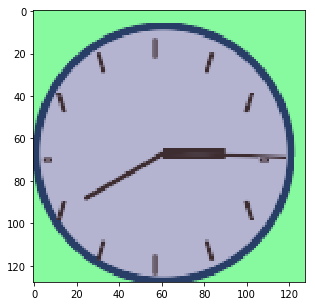

In [10]:
i = np.random.randint(0,n)
print(files[i])
print(temp[i,0],temp[i,1])
print(y[i,:12])
print(y[i,12:])
plt.figure(figsize=(5,5))
plt.imshow(X[i])
plt.show()

In [11]:
p = 0.9
c = int(len(X) * p)

X_train = X[:c]
y_train = y[:c]

X_test = X[c:]
y_test = y[c:]

In [12]:
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D

Using TensorFlow backend.


In [13]:
input_layer = Input(shape=shape)
conv1 = Convolution2D(64, kernel_size=3,activation='relu')(input_layer)
pool1 = MaxPooling2D()(conv1)
conv2 = Convolution2D(128, kernel_size=3,activation='relu')(pool1)
pool2 = MaxPooling2D()(conv2)
conv3 = Convolution2D(256, kernel_size=3,activation='relu')(pool2)
pool3 = MaxPooling2D()(conv3)
conv4 = Convolution2D(512, kernel_size=3,activation='relu')(pool3)
gap = GlobalAveragePooling2D()(conv4)
hidden = Dense(128,activation='relu')(gap)
drop = Dropout(rate=0.5)(hidden)
output1 = Dense(12, activation='softmax')(drop)
output2 = Dense(12, activation='softmax')(drop)

model = Model(inputs=input_layer, outputs=[output1, output2])
model.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy'],
              metrics=['accuracy'], loss_weights=[1., 1])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 126, 126, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 63, 63, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)    

In [14]:
model.fit(X_train, [y_train[:,:12],y_train[:,12:]],
          epochs=5,
          batch_size=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
4500/4500 [==============================] - 381s 85ms/step - loss: 4.9724 - dense_2_loss: 2.4856 - dense_3_loss: 2.4868 - dense_2_acc: 0.0840 - dense_3_acc: 0.0791
Epoch 2/5
4500/4500 [==============================] - 376s 84ms/step - loss: 4.9687 - dense_2_loss: 2.4834 - dense_3_loss: 2.4852 - dense_2_acc: 0.0880 - dense_3_acc: 0.0818
Epoch 3/5
4500/4500 [==============================] - 378s 84ms/step - loss: 4.9679 - dense_2_loss: 2.4828 - dense_3_loss: 2.4851 - dense_2_acc: 0.0867 - dense_3_acc: 0.0867
Epoch 4/5
4500/4500 [==============================] - 401s 89ms/step - loss: 4.9677 - dense_2_loss: 2.4828 - dense_3_loss: 2.4849 - dense_2_acc: 0.0927 - dense_3_acc: 0.0864
Epoch 5/5
4500/4500 [==============================] - 385s 85ms/step - loss: 4.9676 - dense_2_loss: 2.4827 - dense_3_loss: 2.4849 - dense_2_acc: 0.0904 - dense_3_acc: 0.0876


In [15]:
model.evaluate(X_test, [y_test[:,:12],y_test[:,12:]], batch_size=10)

500/500 [==============================] - 13s 26ms/step


[4.968783655166626,
 2.484713191986084,
 2.4840704441070556,
 0.10000000178813934,
 0.07600000128149986]

In [ ]:
path = 'google_images'
files = listdir(path)
len(files)

In [ ]:
for i in range(41):
    img = Image.open(path+'/'+files[i])
    img.thumbnail((128, 128), Image.ANTIALIAS) # resizes image in-place
    img = np.asarray(img)
    print(img.shape)
    if (img.shape[:3] == (128,128,3)):   
        imgplot = plt.imshow(img)
        plt.show()
        pred = model.predict(img.reshape(1,128,128,3))
        h = np.argmax(pred[0])+1
        m = np.argmax(pred[1])*5
        print(str(h)+":"+str(m))
        print(pred)
    else:
        print(i)

In [ ]:
model.save('270319.h5')